## VIDEO TO FRAMES

Esta parte del código requiere la ruta donde se aloja el video, y genera los frames de los videos para el Método 1 y Método 2, no es necesario recortar los videos, o eliminar los frames, el código no procesa los primeros y los últimos frames de cada video.

Solo cambiar la ruta del video

In [ ]:
# Cambiar aquí por el nombre del video a analizar
filename = "G_3_Altair_300824_21_47_DSC0037_Prisma"

In [ ]:
import cv2
import os

# Ruta del video
video_path = (
    f"videos/{filename}.MOV"  # Asume que el video está en una carpeta llamada videos
)

# Extraer el nombre del archivo sin la extensión para usar como nombre de la carpeta
video_name = os.path.splitext(os.path.basename(video_path))[0]

# Crear una carpeta con el nombre del video si no existe
output_folder = os.path.join("data", video_name)
if not os.path.exists(output_folder):
    try:
        os.makedirs(output_folder)
    except OSError:
        print("Error: Creating directory of data")
        exit(1)

# Abrir el video
cam = cv2.VideoCapture(video_path)

# Inicializar el contador de frames
currentframe = 0

while True:
    # Leer un frame del video
    ret, frame = cam.read()

    if ret:
        # Si hay frames disponibles, continuar creando imágenes
        name = os.path.join(output_folder, f"frame{currentframe}.jpg")
        # print(f"Creating... {name}")

        # Guardar la imagen extraída
        cv2.imwrite(name, frame)

        # Incrementar el contador de frames
        currentframe += 1
    else:
        print("Extracted all frames")
        break

# Liberar todos los recursos y cerrar ventanas una vez terminado
cam.release()
cv2.destroyAllWindows()

## Frames Analysis

Aquí se determina la distancia entre los spot de las estrellas del método 1 y el método 2. 

Insertar la ruta donde se guardaron los frames


 Su carpeta tiene 2802 archivos .jpg 

          ....            

Se procesarán los frames del:1120 al:2241

          ....            
No. 1: \frame1120.jpg
          ....            
No. 2241: \frame2241.jpg
          ....            
          ....            

 :: CONSTRUYENDO EL HISTOGRAMA :: 

          ....            
Media (mu): 13.162, Desviación estándar (sigma): 0.402


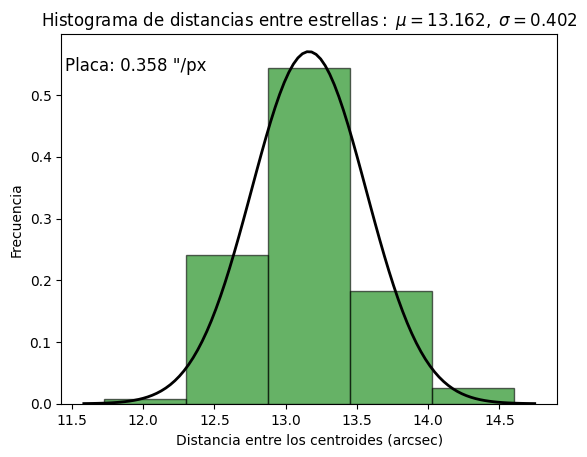

In [2]:
"""________________Distance_IMG______________
Programa que construye el histograma de frecuencias de la separación 
entre dos "spots" (objetos) en el DIMM."""

"""_________________Libraries________________________"""
import cv2
import glob
import numpy as np
from scipy.stats import norm
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import re
"""__________________________________________________"""


"""__________________FUNCTIONS_______________________"""
# Definir una función con parámetros de Open CV
def identify_stars_and_distance(image_path):
    # Cargar imagen con filtro en escala de grises
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


    # Aplicar un umbral para binarizar la imagen y destacar los objetos (estrellas) Este parámetro se puede variar según la intensidad de la estrella
    _, thresh = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY)


    # Encontrar los contornos de los objetos (estrellas)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    # Filtrar unicamente los dos contornos más grandes detectados (asumiendo que son las estrellas)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    
    # Obtener los centros de las dos estrellas
    star_centers = []  #crear un vector para guardar los centros
    for contour in contours:
        M = cv2.moments(contour) #calcula los momentos del contorno, función de Open CV
        if M["m00"] != 0:  # moo es el area del contorno
            cX = int(M["m10"] / M["m00"])  #m10 es el momento espacial para calcular las coordenadas del centroide
            cY = int(M["m01"] / M["m00"])  #m01 es el momento espacial para calcular las coordenadas del centroide
            star_centers.append((cX, cY)) #guardar las coordenadas de los centros encontrados


    # Calcular la distancia entre las dos estrellas
    if len(star_centers) == 2:
        pixel_distance = dist.euclidean(star_centers[0], star_centers[1])
        return(pixel_distance)
    else:
        # print("No se encontraron estrellas.")
        return 0

    # Mostrar la imagen con los centros de las estrellas marcados
    #plt.imshow(image, cmap='gray')
    #plt.title(f"Distancia en pixeles: {pixel_distance:.2f}")
    #plt.show()
    

# Definir una funcion para extraer el numero del frame dek nombre del archivo
def extract_frame_number(filename):
    match = re.search(r'frame(\d+)\.jpg', filename)
    return int(match.group(1)) if match else -1

"""__________________________________________________"""


"""_____________________SCALE________________________"""
scale_size = 0.358  # segundos de arco por px ('' /px)

"""__________________________________________________"""


"""_____________________MAIN_________________________"""
# Abrir carpeta donde se encuentran los frames del video
carpeta = f"data/{filename}"


# Busqueda de los archivos .jpg
archivos = glob.glob(carpeta + r"/*.jpg")

# Ordenar los archivos numéricamente por el número de frame en el nombre asi (0, 1, 2, 3, ...)
archivos.sort(key=extract_frame_number)

# Definir los frames que se procesaran, se escogieron unicamente los frames entre el 40% y el 80% para eliminar errores al inicio y fin
start = int(len(archivos)*0.40)
end = int(len(archivos)*0.80)

nombres = []
for j in archivos:
    if carpeta in j:
        nombres.append(j.replace(carpeta, ""))


if nombres != []:
    l = len(nombres)
    print(f"\n Su carpeta tiene {l} archivos .jpg \n")
    print(f"          ....            ")
    print(f"\nSe procesarán los frames del:{start} al:{end}\n")
    print(f"          ....            ")
    print(f"No. 1: {nombres[start]}")
    print(f"          ....            ")
    print(f"No. {end}: {nombres[end]}")
    print(f"          ....            ")
    print(f"          ....            ")
    print("\n :: CONSTRUYENDO EL HISTOGRAMA :: \n")
    print(f"          ....            ")
else:
    print("\n Su carpeta no tiene archivos .jpg \n")

distances = []


for k in range(start, end):
    # Usar la función en un frame
    identify_stars_and_distance(archivos[k])
    #print(f"archivo {archivos[k]}") #verificar si se están ejecutando los frames en orden
    distances.append(identify_stars_and_distance(archivos[k])*scale_size)

distances = np.array(distances)
no_stars = len(np.where(distances==0)[0])
print(f'No se encontraron estrellas en {no_stars} frames, es decir en el {round(no_stars/(end-start+1)*100,2)}% de ellos')

# Guardar las distancias en un archivo llamado nombre_del_video.dat
np.savetxt(f"{filename}.dat", distances, fmt="%.6f", header="Distancias entre estrellas (arcsec)")

distances = np.loadtxt(f'{filename}.dat')
distances = distances[np.where(distances!=0)]

# Ajuste de los datos a una distribución normal
mu, std = norm.fit(distances)
# Normalizar los valores del histograma
weights = np.ones_like(distances) / len(distances)
# Graficar el histograma con las distancias
count, bins, ignored = plt.hist(distances, weights=weights, bins=15, alpha=0.6, color="g", edgecolor="black")

# Graficar la función de densidad de probabilidad (PDF) ajustada
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

# Normalizar la PDF para que se ajuste al histograma
bin_width = bins[1] - bins[0]
p_normalized = p * bin_width  # Ajuste el área de la PDF al histograma
plt.plot(x, p_normalized, "k", linewidth=2)


# Mostrar los valores de mu y sigma
print(f"Media (mu): {mu:.3f}, Desviación estándar (sigma): {std:.3f}")


# Grafico
plt.title(r"$\mathrm{Histograma\ de\ distancias\ entre\ estrellas:}\ \mu=%.3f,\ \sigma=%.3f$" % (mu, std))
plt.xlabel("Distancia entre los centroides (arcsec)")
plt.ylabel("Frecuencia")
plt.text(0.15, 0.9, f"Placa: {scale_size} \"/px", transform=plt.gca().transAxes, fontsize=12, color='black', ha='center')
plt.show()

### DESENFOQUE Y REGISTRO DEL MOVIMIENTO DIFERENCIAL

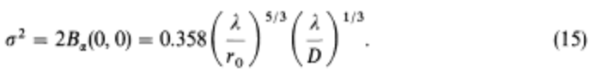

Sarazin & Roddier (1990), definen la varianza en términos del movimiento total como:

$$
\sigma^{2} = 2B_{\alpha}(0,0) = 0.358 \left(\frac{\lambda}{r_0}\right)^{5/3} \left(\frac{\lambda}{D}\right)^{1/3}

$$

Donde $D$ es el diámetro de las aperturas 4.2 cm, $r_0$ es el parámetro de Fried y $\lambda$ es la longitud de onda, en este caso el visible , 0.5 $\mu$ m


In [12]:
Dhole = 4.2  # diametro de la apertura  en cm
dsep = 14.4  # diametro de la separacion de las aperturas en cm

lamb = 0.5  # longitud de onda en micrometros (um)

sq_mu = mu**2

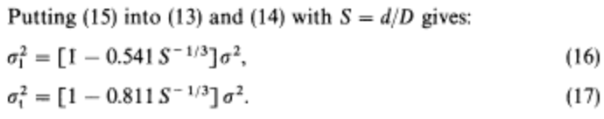

De esta manera se pueden obtener $\sigma (l)$ y $\sigma (t)$

$$
\sigma_{l}^{2} = \left[1 - 0.541 \left(\frac{d}{D}\right)^{-1/3} \right] \sigma^{2}
$$

$$
\sigma_{t}^{2} = \left[1 - 0.811 \left(\frac{d}{D}\right)^{-1/3} \right] \sigma^{2}
$$

In [11]:
sq_mu_l = (1 - 0.541 * (dsep / Dhole)**(-1 / 3)) * sq_mu
sq_mu_t = (1 - 0.811 * (dsep / Dhole)**(-1 / 3)) * sq_mu

De esta manera:

$$
\sigma (l)^2 = 2\lambda^2[0.179/D_{Hole}^{1/3} - 0.097/d_{sep}^{1/3}]r_0(l)^{-5/3}
$$

$$
\sigma (t)^2 = 2\lambda^2[0.179/D_{Hole}^{1/3} - 0.145/d_{sep}^{1/3}]r_0(t)^{-5/3}
$$

Despejando  $r_0$
$$
r_0(l)^{-5/3} = \sigma (l)^2 / {( 2\lambda^2[0.179/D_{Hole}^{1/3} - 0.097/d_{sep}^{1/3}])}
$$

$$
r_0(t)^{-5/3} = \sigma (l)^2 / {( 2\lambda^2[0.179/D_{Hole}^{1/3} - 0.145/d_{sep}^{1/3}])}
$$

In [9]:


r_l =  (sq_mu_l**2 / (2*(lamb/10000)**2*((0.179/Dhole**(1/3))-(0.097/dsep**(1/3)))))**(-3/5)
r_t =  (sq_mu_t**2 / (2*(lamb/10000)**2*((0.179/Dhole**(1/3))-(0.145/dsep**(1/3)))))**(-3/5)
print (f"El valor para el parametro de Fried (l) es: {r_l:.3f}")
print (f"El valor para el parametro de Fried (t) es:{r_t:.3f}")


El valor para el parametro de Fried (l) es: 0.000
El valor para el parametro de Fried (t) es:0.000


Seeing :
$$
FWHM = \Delta \theta = 0.98 \lambda / r_0
$$

In [10]:
FWHM_l = 0.98*lamb/r_l
FWHM_t = 0.98 * lamb / r_t
print (f"El valor del Seeing (l) es: {FWHM_l:.3f}")
print (f"El valor del Seeing (t) es:{FWHM_t:.3f}")

El valor del Seeing (l) es: 65249883.610
El valor del Seeing (t) es:53537397.440
